# Assignment 4
## Econ 8310 - Business Forecasting

This assignment will make use of the bayesian statistical models covered in Lessons 10 to 12.

A/B Testing is a critical concept in data science, and for many companies one of the most relevant applications of data-driven decision-making. In order to improve product offerings, marketing campaigns, user interfaces, and many other user-facing interactions, scientists and engineers create experiments to determine the efficacy of proposed changes. Users are then randomly assigned to either the treatment or control group, and their behavior is recorded.
If the changes that the treatment group is exposed to can be measured to have a benefit in the metric of interest, then those changes are scaled up and rolled out to across all interactions.
Below is a short video detailing the A/B Testing process, in case you want to learn a bit more:
[https://youtu.be/DUNk4GPZ9bw](https://youtu.be/DUNk4GPZ9bw)

For this assignment, you will use an A/B test data set, which was pulled from the Kaggle website (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). I have added the data from the page into Codio for you. It can be found in the cookie_cats.csv file in the file tree. It can also be found at [https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv](https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv)

The variables are defined as follows:

| Variable Name  | Definition |
|----------------|----|
| userid         | A unique number that identifies each player  |
| version        | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) |
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install.  |
| retention1     | Did the player come back and play 1 day after installing?     |
| retention7     | Did the player come back and play 7 days after installing?    |               

### The questions

You will be asked to answer the following questions in a small quiz on Canvas:
1. What was the effect of moving the gate from level 30 to level 40 on 1-day retention rates?
2. What was the effect of moving the gate from level 30 to level 40 on 7-day retention rates?
3. What was the biggest challenge for you in completing this assignment?

You will also be asked to submit a URL to your forked GitHub repository containing your code used to answer these questions.

Data Preview:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Analyzing 1-Day Retention Rate


Output()


Bayesian A/B Test Results for retention_1:
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
difference  0.006  0.003    -0.000      0.012        0.0      0.0    3553.0   
prob_30     0.448  0.002     0.443      0.453        0.0      0.0    3886.0   
prob_40     0.442  0.002     0.438      0.447        0.0      0.0    3551.0   

            ess_tail  r_hat  
difference    2697.0    1.0  
prob_30       2942.0    1.0  
prob_40       2545.0    1.0  


<Figure size 1000x600 with 0 Axes>

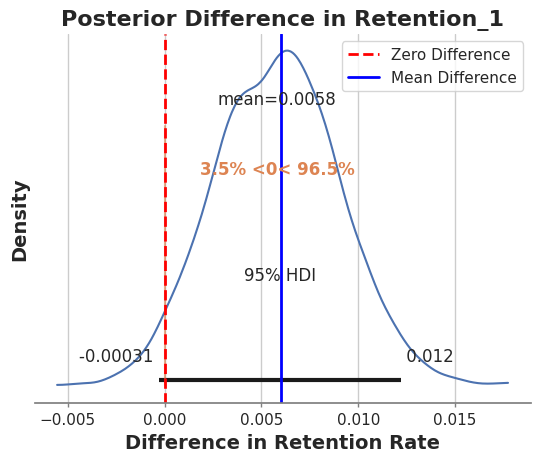


Analyzing 7-Day Retention Rate


Output()


Bayesian A/B Test Results for retention_7:
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
difference  0.008  0.003     0.003      0.013        0.0      0.0    4252.0   
prob_30     0.190  0.002     0.186      0.194        0.0      0.0    4182.0   
prob_40     0.182  0.002     0.179      0.185        0.0      0.0    4053.0   

            ess_tail  r_hat  
difference    2947.0    1.0  
prob_30       2768.0    1.0  
prob_40       2989.0    1.0  


<Figure size 1000x600 with 0 Axes>

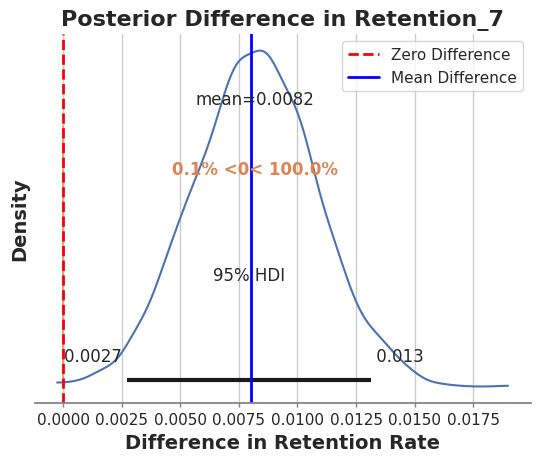

In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# CSV data file
data = pd.read_csv("cookie_cats.csv")

# Display the first few rows to understand the data structure
print("Data Preview:")
print(data.head())

# Seaborn for better plots
sns.set(style="whitegrid")

# Bayesian A/B testing
def bayesian_ab_test(data, retention_metric):
    # Extract retention rates for each version
    retention_30 = data[data['version'] == 'gate_30'][retention_metric]
    retention_40 = data[data['version'] == 'gate_40'][retention_metric]

    # Bayesian modeling
    with pm.Model() as model:
        # Priors for the probabilities of retention
        prob_30 = pm.Beta('prob_30', alpha=1, beta=1)
        prob_40 = pm.Beta('prob_40', alpha=1, beta=1)

        # observed data
        obs_30 = pm.Bernoulli('obs_30', p=prob_30, observed=retention_30)
        obs_40 = pm.Bernoulli('obs_40', p=prob_40, observed=retention_40)

        # Difference between the probabilities
        diff = pm.Deterministic('difference', prob_30 - prob_40)

        # Sampling from the posterior
        trace = pm.sample(2000, chains=2, tune=1000)

    # Summarize the posterior distribution
    print(f"\nBayesian A/B Test Results for {retention_metric}:")
    summary = az.summary(trace, hdi_prob=0.95)
    print(summary)

    # Posterior difference visualization
    plt.figure(figsize=(10, 6))
    az.plot_posterior(trace, var_names=['difference'], ref_val=0, point_estimate='mean', hdi_prob=0.95)
    plt.title(f'Posterior Difference in {retention_metric.capitalize()}', fontsize=16, fontweight='bold')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Difference')
    plt.axvline(summary.loc['difference', 'mean'], color='blue', linestyle='-', linewidth=2, label='Mean Difference')
    plt.xlabel("Difference in Retention Rate", fontsize=14, fontweight='bold')
    plt.ylabel("Density", fontsize=14, fontweight='bold')
    plt.legend()
    plt.show()

# Analyzing 1-day retention rate
print("\nAnalyzing 1-Day Retention Rate")
bayesian_ab_test(data, 'retention_1')

# Analyzing 7-day retention rate
print("\nAnalyzing 7-Day Retention Rate")
bayesian_ab_test(data, 'retention_7')